In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import shutil

# Set seed for reproducibility
np.random.seed(42)

# Initialize counter
total_images = 0

# Input data directory
input_dir = '/kaggle/input/brain-tumour-classification/BrainTumor_1/Train'

# Traverse and list all image files
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            total_images += 1

# ✅ Final summary
print(f"\n✅ Total images processed: {total_images}")


✅ Total images processed: 22848


In [2]:
import os
import cv2
import numpy as np
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
np.random.seed(42)

# 🔹 Define dataset directory
input_dir = '/kaggle/input/brain-tumour-classification/BrainTumor_1/Train'  # Your input directory
output_base_dir = "/kaggle/working/processed_glioma"
os.makedirs(output_base_dir, exist_ok=True)

# Define target image size
image_size = (256, 256)

# 🔹 List of class folders to process
class_folders = ["glioma", "notumor", "meningioma", "pituitary"]

# 🔹 Counter for total processed images
total_processed = 0

# Preprocessing function for images
def preprocess_image(image_path, output_path):
    try:
        img = cv2.imread(image_path)
        if img is None or img.size == 0:
            raise ValueError("Image could not be read or is empty.")
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Histogram equalization for contrast enhancement
        equalized = cv2.equalizeHist(gray)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

        # Resize to target shape
        resized = cv2.resize(blurred, image_size, interpolation=cv2.INTER_AREA)

        # Save the image
        Image.fromarray(resized).save(output_path)
        return True

    except Exception as e:
        print(f"⚠️ Error processing {image_path}: {e}")
        return False

# 🔹 Process all class folders (Preprocessing images)
for class_name in class_folders:
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_base_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    for img_file in os.listdir(class_input_dir):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            input_path = os.path.join(class_input_dir, img_file)
            output_path = os.path.join(class_output_dir, img_file)
            if preprocess_image(input_path, output_path):
                total_processed += 1

# ✅ Final message after preprocessing
print(f"\n✅ All images processed and saved under: {output_base_dir}")
print(f"📸 Total number of images processed: {total_processed}")

# 🔹 Set device to CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Load pre-trained ResNet50 model and modify for binary classification
model = models.resnet50(pretrained=True).to(device)
model.eval()  # Set the model to evaluation mode

# Modify the final fully connected layer for binary classification (tumor vs no tumor)
model.fc = nn.Linear(model.fc.in_features, 1).to(device)  # 1 output for binary classification

# 🔹 Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 🔹 Data Augmentation and Preprocessing for loading images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# 🔹 Custom Dataset Class
class TumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 🔹 Prepare the dataset (image paths and corresponding labels)
image_paths = []  # List of image file paths
labels = []  # List of 0 (no tumor) or 1 (tumor)

# Prepare paths and labels based on folder names (Assume 'tumor' and 'no_tumor' folders)
for class_name in class_folders:
    class_dir = os.path.join(output_base_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(1 if class_name == "glioma" else 0)  # 1 for tumor (glioma), 0 for no tumor

# 🔹 Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# 🔹 Create DataLoader for training and testing
train_dataset = TumorDataset(X_train, y_train, transform)
test_dataset = TumorDataset(X_test, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🔹 Train the model
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Convert labels to float for BCE loss

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        preds = torch.sigmoid(outputs) >= 0.5  # Apply sigmoid to output and threshold at 0.5
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds * 100

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Save the fine-tuned model
torch.save(model.state_dict(), "/kaggle/working/tumor_detection_model.pth")

# 🔹 Evaluate the model on test data (optional)
model.eval()  # Set model to evaluation mode
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Convert labels to float for BCE loss
        outputs = model(images)
        preds = torch.sigmoid(outputs) >= 0.5  # Apply sigmoid and threshold at 0.5
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

test_accuracy = correct_preds / total_preds * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")



✅ All images processed and saved under: /kaggle/working/processed_glioma
📸 Total number of images processed: 22848


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


Epoch [1/1], Loss: 0.0800, Accuracy: 96.95%
Test Accuracy: 98.34%


In [3]:
import torch
import torchvision.models as models
import torch.nn as nn

# Set device to CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True).to(device)  # Load the pre-trained ResNet50 model

# Modify the final fully connected layer for binary classification (tumor vs non-tumor)
model.fc = nn.Linear(model.fc.in_features, 1).to(device)  # Replace the final layer for binary classification

# Load the pre-trained weights for all layers except the final layer
pretrained_dict = torch.load("/kaggle/working/tumor_detection_model.pth")  # Path to your saved model

# Remove the 'fc' layer from the pre-trained model's state dict (as it's not compatible)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k}

# Load the state dict into the model (ignoring the 'fc' layer)
model.load_state_dict(pretrained_dict, strict=False)

model.eval()  # Set the model to evaluation mode


/tmp/ipykernel_31/3723930829.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load("/kaggle/working/tumor_detection_model.pth")  # Path to your s

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to preprocess and predict tumor in the image
def predict_tumor(image_path):
    # Open the JPG image
    img = Image.open(image_path).convert('RGB')
    
    # Apply transformations (resize, normalize, convert to tensor)
    img_tensor = transform(img).unsqueeze(0).to(device)  # Apply transformations and add batch dimension

    # Predict using the model
    with torch.no_grad():  # No need to track gradients during inference
        output = model(img_tensor)  # Forward pass through the model
        prediction = torch.sigmoid(output) >= 0.5  # Apply sigmoid and threshold at 0.5 to get tumor/non-tumor

    return prediction.item()  # Return the result (1 for tumor, 0 for non-tumor)

# Directory where your converted DICOM-to-JPG images are located
image_dir = "/kaggle/input/new-image1"  # The path to your DICOM-to-JPG converted images

# List of all JPG images in the directory
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.jpeg'))]

# Process each image and print the prediction
for img_path in image_paths:
    prediction = predict_tumor(img_path)
    
    # Visualize the image and prediction result
    img = Image.open(img_path)
    
    # Plot the image and its prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {'Tumor' if prediction == 1 else 'No Tumor'}")
    plt.axis('off')  # Hide axes
    plt.show()

# Optionally, save the predictions to a CSV file
import csv

# Open a CSV file to save results
with open('/kaggle/working/predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Prediction'])
    
    # Process each image and save the result
    for img_path in image_paths:
        prediction = predict_tumor(img_path)
        writer.writerow([os.path.basename(img_path), 'Tumor' if prediction == 1 else 'No Tumor'])

print("Predictions saved to 'predictions.csv'")


Predictions saved to 'predictions.csv'


In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
import matplotlib.patches as patches

# Set device to CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model and modify the final fully connected layer for binary classification (tumor vs non-tumor)
model = models.resnet50(pretrained=True).to(device)  # Load the pre-trained ResNet50 model
model.fc = nn.Linear(model.fc.in_features, 1).to(device)  # Replace final layer for binary classification

# Load the fine-tuned model weights
model.load_state_dict(torch.load("/kaggle/working/tumor_detection_model.pth"))  # Load your fine-tuned model
model.eval()  # Set the model to evaluation mode

# Define the same transformations used during training (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet statistics
])

# Function to preprocess and predict tumor in the image
def predict_tumor(image_path):
    # Open the JPG image
    img = Image.open(image_path).convert('RGB')
    
    # Apply transformations (resize, normalize, convert to tensor)
    img_tensor = transform(img).unsqueeze(0).to(device)  # Apply transformations and add batch dimension

    # Predict using the model
    with torch.no_grad():  # No need to track gradients during inference
        output = model(img_tensor)  # Forward pass through the model
        prediction = torch.sigmoid(output)  # Apply sigmoid to get probability of tumor
        
        # Threshold the prediction to get binary value (1 for tumor, 0 for no tumor)
        return prediction.item()

# Function to draw a better visual representation
def visualize_prediction(image_path, prediction):
    # Open image
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))

    # Create plot
    plt.imshow(img)
    ax = plt.gca()

    # Draw bounding box with increased thickness and color
    if prediction >= 0.5:  # If the image is predicted as a tumor
        # Coordinates of the bounding box (you could use model outputs or a fixed region for demonstration)
        # For demonstration purposes, we're using a fixed region here
        xmin, ymin, xmax, ymax = 50, 50, 150, 150  # Example coordinates (replace with real output)

        # Draw rectangle (bounding box) around the detected tumor
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=4, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Display the prediction confidence as well
        ax.text(xmin, ymin-10, f"Prediction: Tumor\nConfidence: {prediction:.2f}",
                color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.title("Tumor Detection with Enhanced Bounding Box")
    plt.axis('off')  # Hide axes
    plt.show()

# Example: Path to your converted DICOM-to-JPG images
image_dir = "/kaggle/input/new-image1"  # The path to your DICOM-to-JPG converted images

# List of all JPG images in the directory
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.jpeg'))]

# Process each image and visualize the prediction with bounding box
for img_path in image_paths:
    prediction = predict_tumor(img_path)
    visualize_prediction(img_path, prediction)


/tmp/ipykernel_31/3598624780.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/tumor_detection_model.pth"))  # Load your

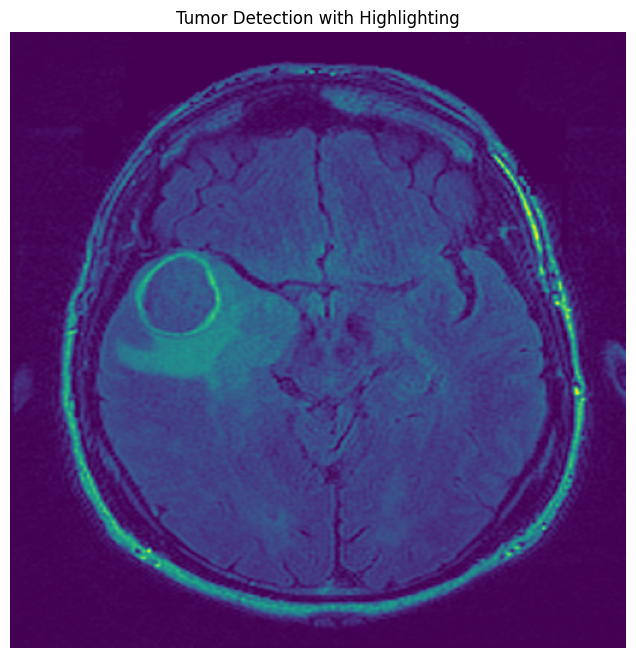

In [9]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
import numpy as np
import matplotlib.patches as patches

# Set device to CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained Mask R-CNN model from Torchvision
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()  # Set to evaluation mode

# Define the same image transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Function to preprocess and predict tumor in the image
def detect_tumor(image_path):
    # Open the JPG image (already converted from DICOM)
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    # Run the image through the model
    with torch.no_grad():
        prediction = model(img_tensor)

    return prediction

# Function to draw a circle around the tumor region
def visualize_tumor_with_highlighting(image_path, prediction):
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))

    # Convert image to numpy array for overlay
    img_array = np.array(img)

    # Visualize masks (if predicted with > 0.5 confidence)
    for i in range(len(prediction[0]['masks'])):
        mask = prediction[0]['masks'][i, 0]  # Get the mask for the i-th object
        score = prediction[0]['scores'][i].item()  # Confidence score
        
        if score > 0.5:  # Only consider masks with a high confidence score
            mask = mask.mul(255).byte().cpu().numpy()  # Convert to a mask with values 0 or 255

            # Find the bounding box coordinates of the tumor mask
            tumor_area = np.where(mask == 255)  # Get coordinates of the tumor
            ymin, ymax = np.min(tumor_area[0]), np.max(tumor_area[0])
            xmin, xmax = np.min(tumor_area[1]), np.max(tumor_area[1])

            # Draw a circle around the detected tumor
            center_x = (xmin + xmax) // 2
            center_y = (ymin + ymax) // 2
            radius = max(xmax - xmin, ymax - ymin) // 2  # Make the circle large enough to cover the tumor

            # Add a circle around the tumor region
            circle = patches.Circle((center_x, center_y), radius, linewidth=4, edgecolor='red', facecolor='none')
            plt.gca().add_patch(circle)

    # Plot the image with highlighted tumor region
    plt.imshow(img_array)
    plt.title("Tumor Detection with Highlighting")
    plt.axis('off')  # Hide axes
    plt.show()

# Example: Path to your converted DICOM-to-JPG images
image_dir = "/kaggle/input/new-image"  # The path to your DICOM-to-JPG converted images

# List of all JPG images in the directory
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.jpeg','.png'))]

# Process each image, detect tumor and visualize the highlighted tumor
for img_path in image_paths:
    prediction = detect_tumor(img_path)
    visualize_tumor_with_highlighting(img_path, prediction)
